# Read data from .mat and plot FGM (mooring mean)

In [1]:
# %matplotlib notebook
%matplotlib inline
import numpy as np
import pandas as pd
import xarray as xr
import scipy as sp
import matplotlib.pyplot as plt
import scipy.io as sio
import io
import gsw

from scipy import integrate
from matplotlib import cm


In [2]:
# load time-mean mooring data
mdirec='/Users/tantanmeow/Desktop/WORK/2018-2019/Jesse/sp-tg/';

data0 = sio.loadmat(mdirec+'data/mooring_averages.mat',squeeze_me = True,struct_as_record = False)
type(data0)
dict.keys(data0)

dict_keys(['__header__', '__version__', '__globals__', 'M5', 'P1', 'P3', 'P4', 'T1', 'T2', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10', 'T11', 'T12'])

In [3]:
# load FGM outputs from a .mat dataset 
data_name = 'TG_SI_mean_ex1.mat'
data = sio.loadmat(mdirec + 'codes/' + data_name,squeeze_me = True,struct_as_record = False)
type(data)
dict.keys(data)

dict_keys(['__header__', '__version__', '__globals__', 'B', 'CI', 'CL', 'CR', 'GR', 'II', 'K', 'KFGM', 'L', 'N2', 'Ri', 'V', 'Vz', 'Vzz', 'W', 'botz', 'site', 'zw'])

In [4]:
# Growth rate, imaginary phase speed, real phase speed, numbers of zero-crossing, wave vector of the FGM
# GR = xr.DataArray(data['GR'], coords={"site": data['site'], "0-crossings": ("site",data['II'])}, dims=["site"])
GR = xr.DataArray(data['GR'], coords={"site": data['site']}, dims=["site"], attrs={'longname': '$\sigma$: $hr^{-1}$'})
CI = xr.DataArray(data['CI'], coords={"site": data['site']}, dims=["site"])
CR = xr.DataArray(data['CR'], coords={"site": data['site']}, dims=["site"])
II = xr.DataArray(data['II'], coords={"site": data['site']}, dims=["site"], attrs={'longname': '0-crossings'})
KFGM = xr.DataArray(data['KFGM'], coords={"site": data['site'], "vector": ['k' , 'l']}, dims=["site" , "vector"])

# profiles
B = xr.DataArray(data['B'], coords={"z":data['zw'], "site": data['site']}, dims=["z" , "site"])
N2 = xr.DataArray(data['N2'], coords={"z":data['zw'], "site": data['site']}, dims=["z" , "site"])
Ri = xr.DataArray(data['Ri'], coords={"z":data['zw'], "site": data['site']}, dims=["z" , "site"])
V = xr.DataArray(data['V'], coords={"z":data['zw'], "site": data['site']}, dims=["z" , "site"])
Vz = xr.DataArray(data['Vz'], coords={"z":data['zw'], "site": data['site']}, dims=["z" , "site"])
Vzz = xr.DataArray(data['Vzz'], coords={"z":data['zw'], "site": data['site']}, dims=["z" , "site"])

botz = xr.DataArray(data['botz'], coords={"site": data['site']}, dims=["site"])

# FGM in terms of w
W = xr.DataArray(data['W'], coords={"z":data['zw'], "site": data['site']}, dims=["z" , "site"])
# critical levels
CL = xr.DataArray(data['CL'], coords={"site": data['site'], "n": np.arange(10)}, dims=["site" , "n"])

FGM_mean = xr.Dataset({'GR': (['site'], 2*np.pi/GR/3600), 
                       'CI': (['site'], CI),
                       'CR': (['site'], CR),
                       'II': (['site'], II), 
                       'K': (['site','vector'], KFGM),
                       'b': (['z', 'site'], B),
                       'N2': (['z', 'site'], N2),
                       'Ri': (['z', 'site'], Ri),
                       'V': (['z', 'site'], V),
                       'Vz': (['z', 'site'], Vz),
                       'Vzz': (['z', 'site'], Vzz),
                       'W': (['z', 'site'], W),
                       'CL': (['site', 'n'], CL),
                       'botz': (['site'], botz)},
                       coords={'site': data['site'],
                               'z': data['zw'],
                               'n': np.arange(10)},
                       attrs={'title': 'FGM, mean mooring profiles'})

In [5]:
EB=['P4','T8','T1','T2','T4','T6','T5']
WB=['T12','M5','T9','T10','T11']
OT=['P1','P3','T7']

Plot site vs. growth rate, colorbar representing the number of zero-crossings

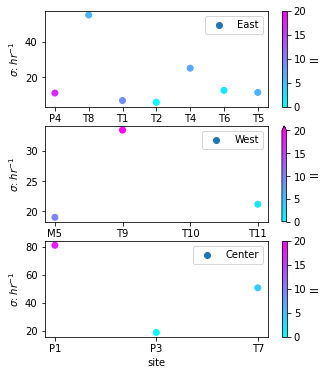

In [6]:
fig, ax =  plt.subplots(nrows=3, ncols=1, figsize=(5, 6))
FGM_mean.loc[dict(site=EB)].plot.scatter(x='site', y='GR', hue='II', marker='o',label='East',
                             ax=ax[0], cmap=cm.cool, vmax=20, vmin=0, add_guide=True)
ax[0].set_ylabel('$\sigma$: $hr^{-1}$')
ax[0].legend()
FGM_mean.loc[dict(site=WB)].plot.scatter(x='site', y='GR', hue='II', marker='o',label='West',
                             ax=ax[1], cmap=cm.cool, vmax=20, vmin=0, add_guide=True)
ax[1].set_ylabel('$\sigma$: $hr^{-1}$')
ax[1].legend()
FGM_mean.loc[dict(site=OT)].plot.scatter(x='site', y='GR', hue='II', marker='o',label='Center',
                             ax=ax[-1], cmap=cm.cool, vmax=20, vmin=0, add_guide=True)
ax[-1].set_ylabel('$\sigma$: $hr^{-1}$')
ax[-1].legend()

Plot site vs. critical level, colorbar representing the growth rate, black profiles show v

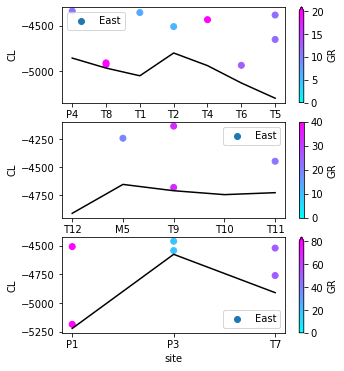

In [7]:
fig, ax =  plt.subplots(nrows=3, ncols=1, figsize=(5, 6))
FGM_mean.loc[dict(site=EB)].plot.scatter(x='site', y='CL', hue='GR', marker='o',label='East',
                             ax=ax[0], cmap=cm.cool, vmax=20, vmin=0, add_guide=True)
ax[0].plot(FGM_mean.botz.loc[dict(site=EB)].site, FGM_mean.botz.loc[dict(site=EB)].data,c='k')
ax[0].legend()
FGM_mean.loc[dict(site=WB)].plot.scatter(x='site', y='CL', hue='GR', marker='o',label='East',
                             ax=ax[1], cmap=cm.cool, vmax=40, vmin=0, add_guide=True)
ax[1].plot(FGM_mean.botz.loc[dict(site=WB)].site, FGM_mean.botz.loc[dict(site=WB)].data,c='k')
ax[1].legend()
FGM_mean.loc[dict(site=OT)].plot.scatter(x='site', y='CL', hue='GR', marker='o',label='East',
                             ax=ax[-1], cmap=cm.cool, vmax=80, vmin=0, add_guide=True)
ax[-1].plot(FGM_mean.botz.loc[dict(site=OT)].site, FGM_mean.botz.loc[dict(site=OT)].data,c='k')
ax[-1].legend()

# Read data from .mat and plot FGM (CTD&LADCP snapshot)

Raw profiles (snapshots) have many overturns (especially near sea bottom) and cause violet-shift of the growth rate, suggesting convective instability. As Larry suggested, I sorted the buoyancy profiles to form a stable configuration and made sure $N^2>0$ everywhere. I did not process the velocity profiles.

In [8]:
# load FGM outputs from a .mat dataset 
data_name = 'TG_SI_snapshot_ex1.mat'
data = sio.loadmat(mdirec + 'codes/' + data_name,squeeze_me = True,struct_as_record = False)
type(data)
dict.keys(data)

dict_keys(['__header__', '__version__', '__globals__', 'B', 'CI', 'CL', 'CR', 'GR', 'II', 'K', 'KFGM', 'L', 'LAT', 'LON', 'N2', 'Ri', 'V', 'Vz', 'Vzz', 'W', 'zw'])

In [9]:
# Growth rate, imaginary phase speed, real phase speed, numbers of zero-crossing, wave vector of the FGM
# GR = xr.DataArray(data['GR'], coords={"site": data['site'], "0-crossings": ("site",data['II'])}, dims=["site"])
GR = xr.DataArray(data['GR'], coords={"site": np.arange(len(data['LON']))}, dims=["site"], attrs={'longname': '$\sigma$: $hr^{-1}$'})
CI = xr.DataArray(data['CI'], coords={"site": np.arange(len(data['LON']))}, dims=["site"])
CR = xr.DataArray(data['CR'], coords={"site": np.arange(len(data['LON']))}, dims=["site"])
II = xr.DataArray(data['II'], coords={"site": np.arange(len(data['LON']))}, dims=["site"], attrs={'longname': '0-crossings'})
KFGM = xr.DataArray(data['KFGM'], coords={"site": np.arange(len(data['LON'])), "vector": ['k' , 'l']}, dims=["site" , "vector"])
LON = xr.DataArray(data['LON'], coords={"site": np.arange(len(data['LON']))}, dims=["site"])
LAT = xr.DataArray(data['LAT'], coords={"site": np.arange(len(data['LON']))}, dims=["site"])

# profiles
B = xr.DataArray(data['B'], coords={"z":data['zw'], "site": np.arange(len(data['LON']))}, dims=["z" , "site"])
N2 = xr.DataArray(data['N2'], coords={"z":data['zw'], "site": np.arange(len(data['LON']))}, dims=["z" , "site"])
Ri = xr.DataArray(data['Ri'], coords={"z":data['zw'], "site": np.arange(len(data['LON']))}, dims=["z" , "site"])
V = xr.DataArray(data['V'], coords={"z":data['zw'], "site": np.arange(len(data['LON']))}, dims=["z" , "site"])
Vz = xr.DataArray(data['Vz'], coords={"z":data['zw'], "site": np.arange(len(data['LON']))}, dims=["z" , "site"])
Vzz = xr.DataArray(data['Vzz'], coords={"z":data['zw'], "site": np.arange(len(data['LON']))}, dims=["z" , "site"])

# FGM in terms of w
W = xr.DataArray(data['W'], coords={"z":data['zw'], "site": np.arange(len(data['LON']))}, dims=["z" , "site"])
# critical levels
CL = xr.DataArray(data['CL'], coords={"site": np.arange(len(data['LON'])), "n": np.arange(data['CL'].shape[-1])}, dims=["site" , "n"])

FGM_snapshot = xr.Dataset({'GR': (['site'], 2*np.pi/GR/3600), 
                       'CI': (['site'], CI),
                       'CR': (['site'], CR),
                       'II': (['site'], II), 
                       'K': (['site','vector'], KFGM),
                       'LON': (['site'], LON), 
                       'LAT': (['site'], LAT), 
                       'b': (['z', 'site'], B),
                       'N2': (['z', 'site'], N2),
                       'Ri': (['z', 'site'], Ri),
                       'V': (['z', 'site'], V),
                       'Vz': (['z', 'site'], Vz),
                       'Vzz': (['z', 'site'], Vzz),
                       'W': (['z', 'site'], W),
                       'CL': (['site', 'n'], CL)},
                       coords={'site': np.arange(len(data['LON'])),
                               'z': data['zw'],
                               'n': np.arange(data['CL'].shape[-1])},
                       attrs={'title': 'FGM, CTD/LADCP profiles'})

Plot site vs. growth rate

In [10]:
topo = xr.open_dataset('/Users/tantanmeow/WORK/larry-data/sp_model_bottom_velocities.nc')
BottomDepth = -topo.BottomDepth

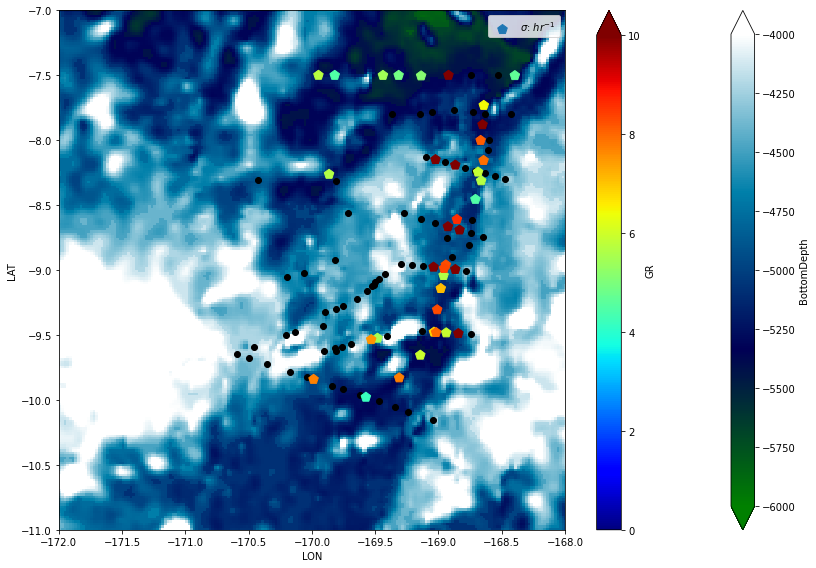

In [11]:
fig, ax =  plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
BottomDepth.plot(ax=ax, xlim=[-172, -168], ylim=[-11, -7], vmax=-4000, vmin=-6000, cmap=cm.ocean)
FGM_snapshot.plot.scatter(x='LON', y='LAT',c='k')
FGM_snapshot.plot.scatter(x='LON', y='LAT', hue='GR', marker='p', s=100, label='$\sigma$: $hr^{-1}$',
                             ax=ax, cmap=cm.jet, vmax=10, vmin=0, add_guide=True)
ax.legend()
fig.tight_layout()

# Read data from .mat and plot FGM (tow-yo)

In [12]:
def dataFGM(section):
    import os
    import glob

    towyo_files = np.sort(glob.glob(os.path.join(mdirec + 'codes/TG_SI_TY_' + section + "*ex1*")))

    # Growth rate, imaginary phase speed, real phase speed, numbers of zero-crossing, wave vector of the FGM
    GRs = np.squeeze(np.concatenate([sio.loadmat(file)["GR"] for file in towyo_files] , axis=0))
    CIs = np.squeeze(np.concatenate([sio.loadmat(file)["CI"] for file in towyo_files] , axis=0))
    CRs = np.squeeze(np.concatenate([sio.loadmat(file)["CR"] for file in towyo_files] , axis=0))
    IIs = np.squeeze(np.concatenate([sio.loadmat(file)["II"] for file in towyo_files] , axis=0))
    KFGMs = np.squeeze(np.concatenate([sio.loadmat(file)["KFGM"] for file in towyo_files] , axis=0))
    LONs = np.squeeze(np.concatenate([sio.loadmat(file)["LON"] for file in towyo_files] , axis=-1))
    LATs = np.squeeze(np.concatenate([sio.loadmat(file)["LAT"] for file in towyo_files] , axis=-1))

    # profiles
    Bs = np.squeeze(np.concatenate([sio.loadmat(file)["B"] for file in towyo_files] , axis=-1))
    N2s = np.squeeze(np.concatenate([sio.loadmat(file)["N2"] for file in towyo_files] , axis=-1))
    Ris = np.squeeze(np.concatenate([sio.loadmat(file)["Ri"] for file in towyo_files] , axis=-1))
    Vs = np.squeeze(np.concatenate([sio.loadmat(file)["V"] for file in towyo_files] , axis=-1))
    Vzs = np.squeeze(np.concatenate([sio.loadmat(file)["Vz"] for file in towyo_files] , axis=-1))
    Vzzs = np.squeeze(np.concatenate([sio.loadmat(file)["Vzz"] for file in towyo_files] , axis=-1))

    # FGM in terms of w
    Ws = np.squeeze(np.concatenate([sio.loadmat(file)["W"] for file in towyo_files] , axis=-1))
    # CLs = np.squeeze(np.concatenate([sio.loadmat(file)["CL"] for file in towyo_files] , axis=0))

    towyo_files_others = np.sort(glob.glob(os.path.join(mdirec[:-6] + 'proc_data/TY_' + section + "*")))

    # interface height, bottom height, crtical level
    zw = np.squeeze(sio.loadmat(towyo_files[0])["zw"])
    ideps = np.squeeze(np.concatenate([sio.loadmat(file)["zo"] for file in towyo_files_others] , axis=1))
    bdeps = np.squeeze(np.concatenate([sio.loadmat(file)["bdepth"] for file in towyo_files_others] , axis=1))    
    cdeps = np.zeros(LONs.shape, dtype='f')
    nans = np.isnan(np.nanmax(Ws.real, axis=0))
    cdeps[~nans] = zw[np.int_(np.nanargmax(Ws.real[:,~nans], axis=0))]
    cdeps[nans] = np.nan
    
    FGM_towyo = xr.Dataset({'GR': (['site'], 2*np.pi/GRs/3600), 
                           'CI': (['site'], CIs),
                           'CR': (['site'], CRs),
                           'II': (['site'], IIs), 
                           'K': (['site','vector'], KFGMs),
                           'LON': (['site'], LONs), 
                           'LAT': (['site'], LATs), 
                           'zo': (['site'], ideps), 
                           'bdepth': (['site'], -bdeps),
                           'cdepth': (['site'], cdeps),
                           'iab': (['site'], ideps+bdeps),
                           'cab': (['site'], cdeps+bdeps),
                           'b': (['z', 'site'], Bs),
                           'N2': (['z', 'site'], N2s),
                           'Ri': (['z', 'site'], Ris),
                           'V': (['z', 'site'], Vs),
                           'Vz': (['z', 'site'], Vzs),
                           'Vzz': (['z', 'site'], Vzzs), #                        'CL': (['site', 'n'], CLs),
                           'W': (['z', 'site'], Ws)},
                           coords={'site': np.arange(len(LONs)),
                                   'z': zw}, #,'n': np.arange(CLs.shape[-1])
                           attrs={'title': 'FGM, tow-yo profiles'})
    return FGM_towyo

In [13]:
mdirec='/Users/tantanmeow/Desktop/WORK/2018-2019/Jesse/sp-tg/'
FGM_towyo = dataFGM("P")
FGM_towyo_P2 = dataFGM("P2")
FGM_towyo_P4 = dataFGM("P4")
FGM_towyo_P5 = dataFGM("P5")

<ipython-input-12-8b7321b496c5>:35: RuntimeWarning: All-NaN slice encountered
  nans = np.isnan(np.nanmax(Ws.real, axis=0))


## 1. Plot site vs. growth rate

In [14]:
topo = xr.open_dataset('/Users/tantanmeow/WORK/larry-data/sp_model_bottom_velocities.nc')
BottomDepth = -topo.BottomDepth

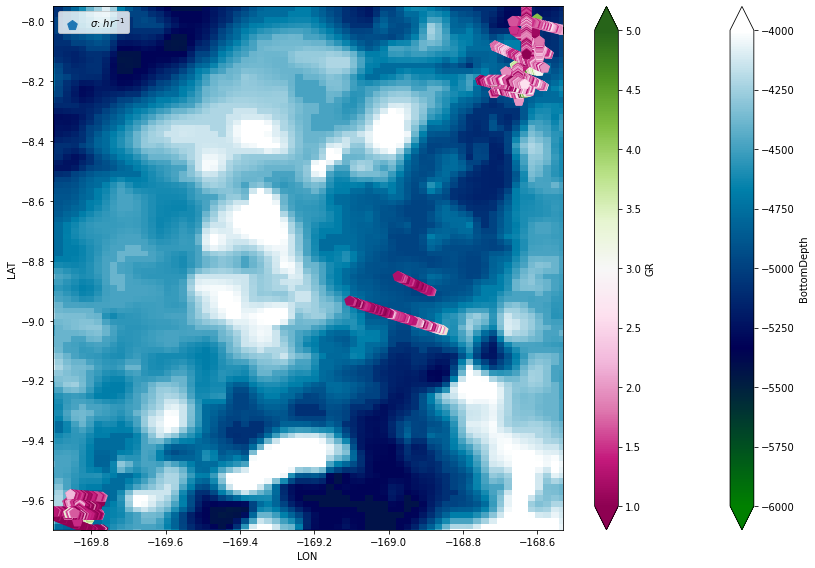

In [15]:
fig, ax =  plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
BottomDepth.plot(ax=ax, xlim=[FGM_towyo.LON.min(), FGM_towyo.LON.max()], ylim=[FGM_towyo.LAT.min(), FGM_towyo.LAT.max()], vmax=-4000, vmin=-6000, cmap=cm.ocean)
FGM_towyo.plot.scatter(x='LON', y='LAT', c='k', ax=ax)
FGM_towyo.plot.scatter(x='LON', y='LAT', hue='GR', marker='p', s=100, label='$\sigma$: $hr^{-1}$',
                             ax=ax, cmap=cm.PiYG, vmax=5, vmin=1, add_guide=True)
ax.legend()
fig.tight_layout()

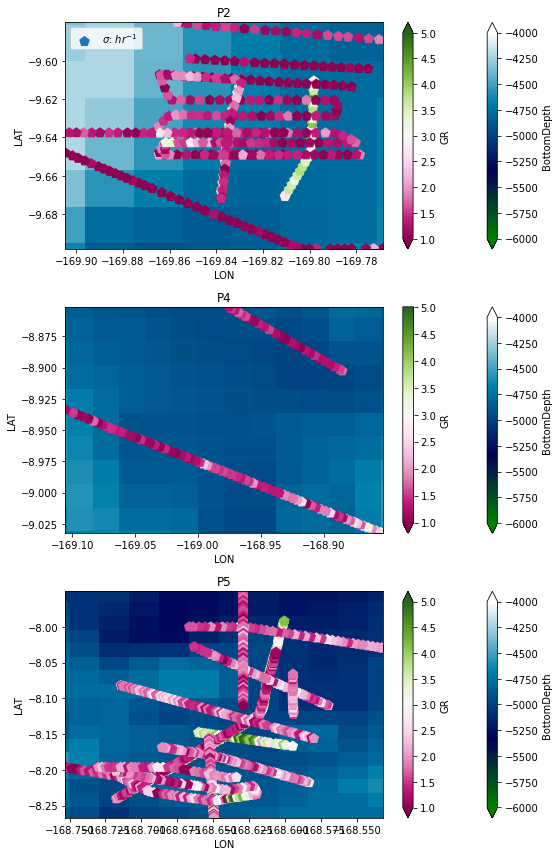

In [16]:
fig, ax =  plt.subplots(nrows=3, ncols=1, figsize=(8, 12))

BottomDepth.plot(ax=ax[0], xlim=[FGM_towyo_P2.LON.min(), FGM_towyo_P2.LON.max()], ylim=[FGM_towyo_P2.LAT.min(), FGM_towyo_P2.LAT.max()], vmax=-4000, vmin=-6000, cmap=cm.ocean)
FGM_towyo_P2.plot.scatter(x='LON', y='LAT', c='k', ax=ax[0])
FGM_towyo_P2.plot.scatter(x='LON', y='LAT', hue='GR', marker='p', s=100, label='$\sigma$: $hr^{-1}$',
                          cmap=cm.PiYG, vmax=5, vmin=1, add_guide=True, ax=ax[0])
ax[0].legend()
ax[0].set_title('P2')

BottomDepth.plot(ax=ax[1], xlim=[FGM_towyo_P4.LON.min(), FGM_towyo_P4.LON.max()], ylim=[FGM_towyo_P4.LAT.min(), FGM_towyo_P4.LAT.max()], vmax=-4000, vmin=-6000, cmap=cm.ocean)
FGM_towyo_P4.plot.scatter(x='LON', y='LAT', c='k', ax=ax[1])
FGM_towyo_P4.plot.scatter(x='LON', y='LAT', hue='GR', marker='p', s=100, label='$\sigma$: $hr^{-1}$',
                          cmap=cm.PiYG, vmax=5, vmin=1, add_guide=True, ax=ax[1])
ax[1].set_title('P4')
BottomDepth.plot(ax=ax[-1], xlim=[FGM_towyo_P5.LON.min(), FGM_towyo_P5.LON.max()], ylim=[FGM_towyo_P5.LAT.min(), FGM_towyo_P5.LAT.max()], vmax=-4000, vmin=-6000, cmap=cm.ocean)
FGM_towyo_P5.plot.scatter(x='LON', y='LAT', c='k', ax=ax[-1])
FGM_towyo_P5.plot.scatter(x='LON', y='LAT', hue='GR', marker='p', s=100, label='$\sigma$: $hr^{-1}$',
                          cmap=cm.PiYG, vmax=5, vmin=1, add_guide=True, ax=ax[-1])
ax[-1].set_title('P5')

fig.tight_layout()

## 2. Plot site vs. critical level above bottom

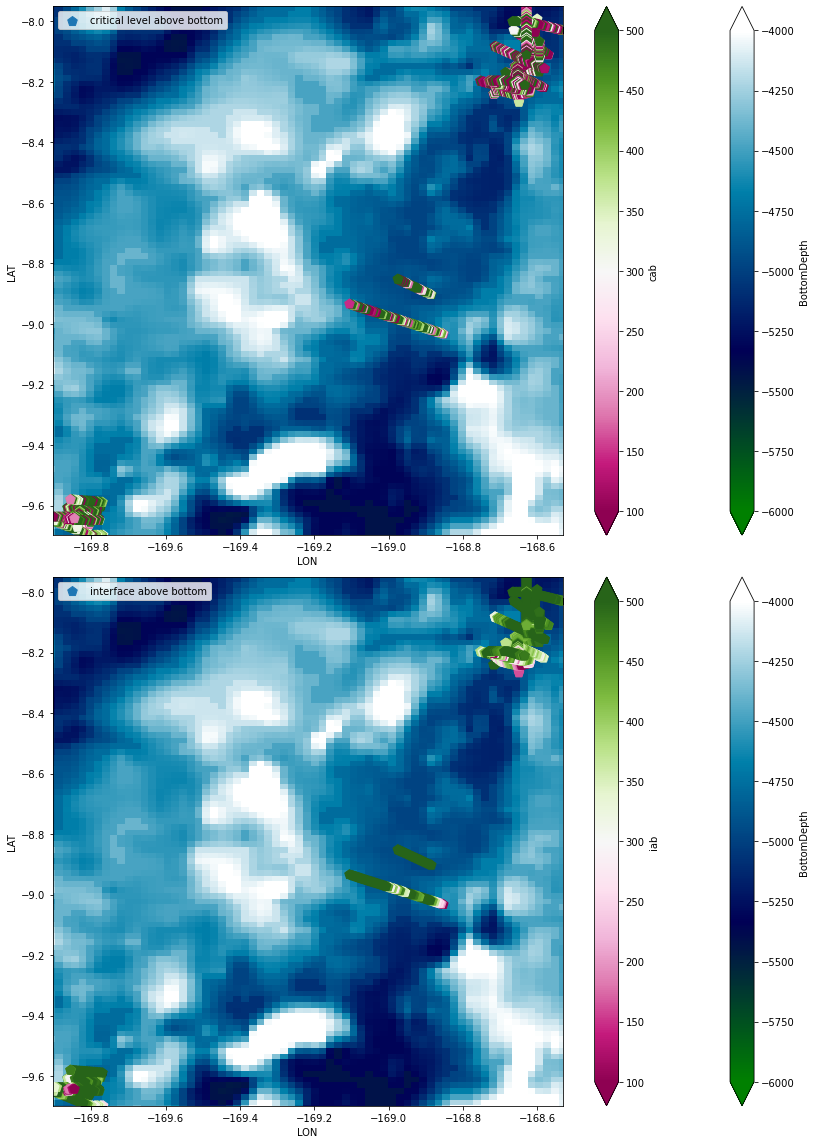

In [17]:
fig, ax =  plt.subplots(nrows=2, ncols=1, figsize=(12, 16))
BottomDepth.plot(ax=ax[0], xlim=[FGM_towyo.LON.min(), FGM_towyo.LON.max()], ylim=[FGM_towyo.LAT.min(), FGM_towyo.LAT.max()], vmax=-4000, vmin=-6000, cmap=cm.ocean)
FGM_towyo.plot.scatter(x='LON', y='LAT', c='k', ax=ax[0])
FGM_towyo.plot.scatter(x='LON', y='LAT', hue='cab', marker='p', s=100, label='critical level above bottom',
                             ax=ax[0], cmap=cm.PiYG, vmax=500, vmin=100, add_guide=True)
ax[0].legend()

BottomDepth.plot(ax=ax[1], xlim=[FGM_towyo.LON.min(), FGM_towyo.LON.max()], ylim=[FGM_towyo.LAT.min(), FGM_towyo.LAT.max()], vmax=-4000, vmin=-6000, cmap=cm.ocean)
FGM_towyo.plot.scatter(x='LON', y='LAT', c='k', ax=ax[1])
FGM_towyo.plot.scatter(x='LON', y='LAT', hue='iab', marker='p', s=100, label='interface above bottom',
                             ax=ax[1], cmap=cm.PiYG, vmax=500, vmin=100, add_guide=True)
ax[1].legend()

fig.tight_layout()

<ipython-input-18-c8255bacf86d>:21: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.tight_layout()


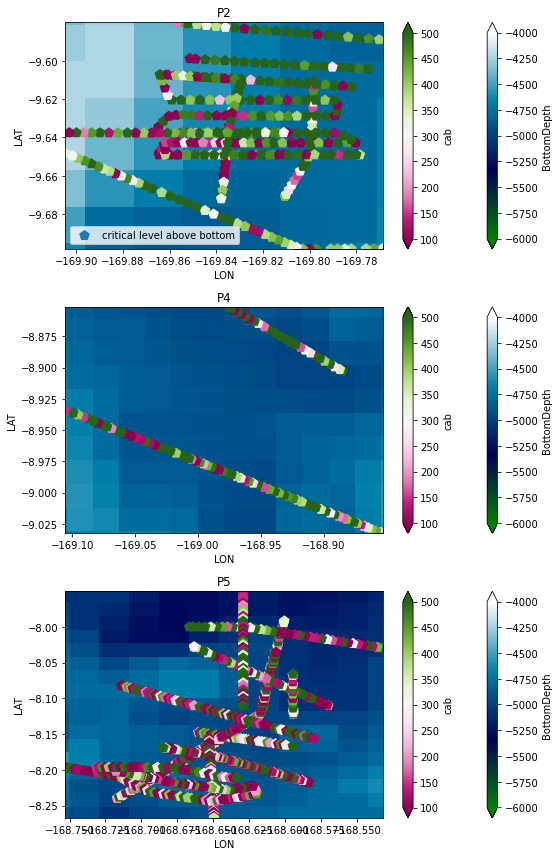

In [18]:
fig, ax =  plt.subplots(nrows=3, ncols=1, figsize=(8, 12))

BottomDepth.plot(ax=ax[0], xlim=[FGM_towyo_P2.LON.min(), FGM_towyo_P2.LON.max()], ylim=[FGM_towyo_P2.LAT.min(), FGM_towyo_P2.LAT.max()], vmax=-4000, vmin=-6000, cmap=cm.ocean)
FGM_towyo_P2.plot.scatter(x='LON', y='LAT', c='k', ax=ax[0])
FGM_towyo_P2.plot.scatter(x='LON', y='LAT', hue='cab', marker='p', s=100, label='critical level above bottom',
                          cmap=cm.PiYG, vmax=500, vmin=100, add_guide=True, ax=ax[0])
ax[0].legend()
ax[0].set_title('P2')

BottomDepth.plot(ax=ax[1], xlim=[FGM_towyo_P4.LON.min(), FGM_towyo_P4.LON.max()], ylim=[FGM_towyo_P4.LAT.min(), FGM_towyo_P4.LAT.max()], vmax=-4000, vmin=-6000, cmap=cm.ocean)
FGM_towyo_P4.plot.scatter(x='LON', y='LAT', c='k', ax=ax[1])
FGM_towyo_P4.plot.scatter(x='LON', y='LAT', hue='cab', marker='p', s=100, label='critical level above bottom',
                          cmap=cm.PiYG, vmax=500, vmin=100, add_guide=True, ax=ax[1])
ax[1].set_title('P4')
BottomDepth.plot(ax=ax[-1], xlim=[FGM_towyo_P5.LON.min(), FGM_towyo_P5.LON.max()], ylim=[FGM_towyo_P5.LAT.min(), FGM_towyo_P5.LAT.max()], vmax=-4000, vmin=-6000, cmap=cm.ocean)
FGM_towyo_P5.plot.scatter(x='LON', y='LAT', c='k', ax=ax[-1])
FGM_towyo_P5.plot.scatter(x='LON', y='LAT', hue='cab', marker='p', s=100, label='critical level above bottom',
                          cmap=cm.PiYG, vmax=500, vmin=100, add_guide=True, ax=ax[-1])
ax[-1].set_title('P5')

fig.tight_layout()

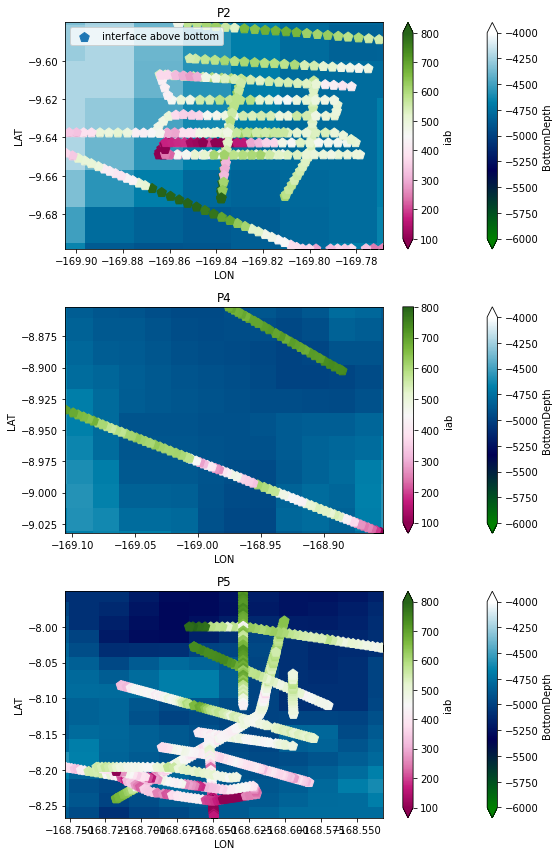

In [19]:
fig, ax =  plt.subplots(nrows=3, ncols=1, figsize=(8, 12))

BottomDepth.plot(ax=ax[0], xlim=[FGM_towyo_P2.LON.min(), FGM_towyo_P2.LON.max()], ylim=[FGM_towyo_P2.LAT.min(), FGM_towyo_P2.LAT.max()], vmax=-4000, vmin=-6000, cmap=cm.ocean)
FGM_towyo_P2.plot.scatter(x='LON', y='LAT', c='k', ax=ax[0])
FGM_towyo_P2.plot.scatter(x='LON', y='LAT', hue='iab', marker='p', s=100, label='interface above bottom',
                          cmap=cm.PiYG, vmax=800, vmin=100, add_guide=True, ax=ax[0])
ax[0].legend()
ax[0].set_title('P2')

BottomDepth.plot(ax=ax[1], xlim=[FGM_towyo_P4.LON.min(), FGM_towyo_P4.LON.max()], ylim=[FGM_towyo_P4.LAT.min(), FGM_towyo_P4.LAT.max()], vmax=-4000, vmin=-6000, cmap=cm.ocean)
FGM_towyo_P4.plot.scatter(x='LON', y='LAT', c='k', ax=ax[1])
FGM_towyo_P4.plot.scatter(x='LON', y='LAT', hue='iab', marker='p', s=100, label='interface above bottom',
                          cmap=cm.PiYG, vmax=800, vmin=100, add_guide=True, ax=ax[1])
ax[1].set_title('P4')
BottomDepth.plot(ax=ax[-1], xlim=[FGM_towyo_P5.LON.min(), FGM_towyo_P5.LON.max()], ylim=[FGM_towyo_P5.LAT.min(), FGM_towyo_P5.LAT.max()], vmax=-4000, vmin=-6000, cmap=cm.ocean)
FGM_towyo_P5.plot.scatter(x='LON', y='LAT', c='k', ax=ax[-1])
FGM_towyo_P5.plot.scatter(x='LON', y='LAT', hue='iab', marker='p', s=100, label='interface above bottom',
                          cmap=cm.PiYG, vmax=800, vmin=100, add_guide=True, ax=ax[-1])
ax[-1].set_title('P5')

fig.tight_layout()

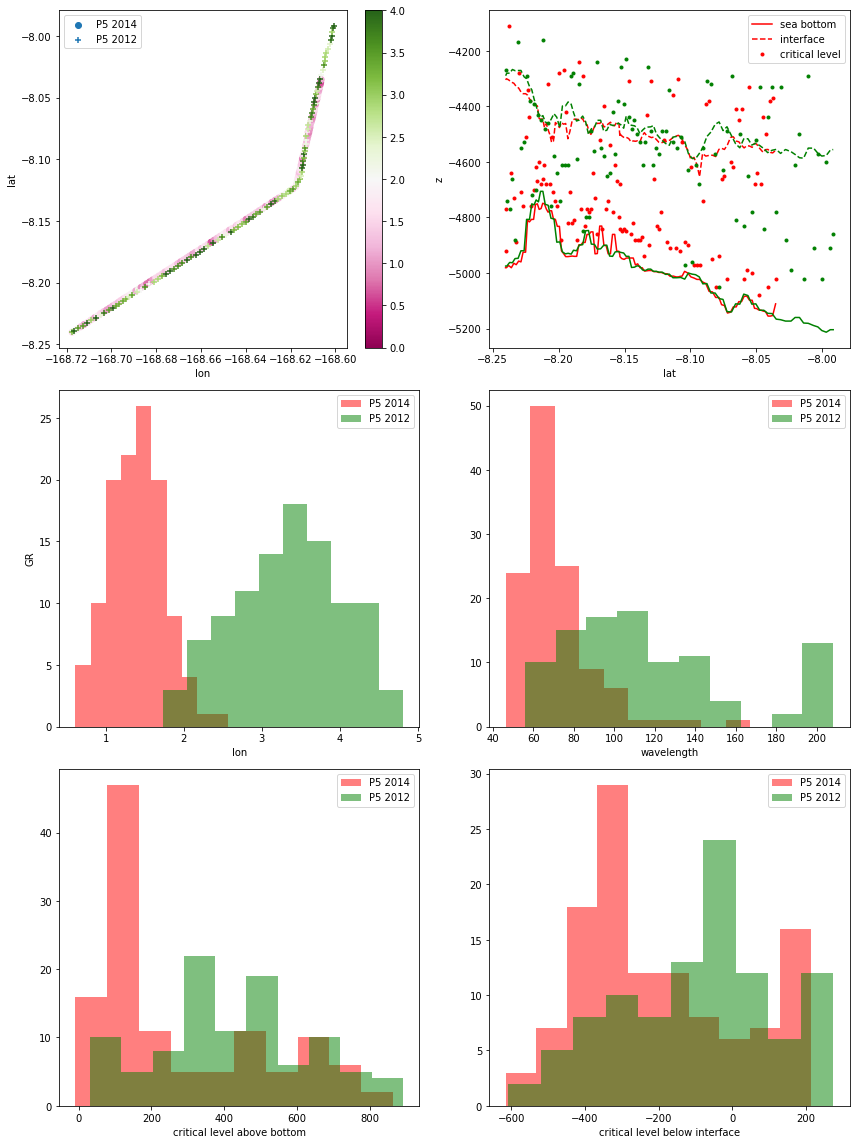

In [20]:
# a closer look at a repeated along-path section, (P5 2012 vs 2014)
fig, ax =  plt.subplots(nrows=3, ncols=2, figsize=(12, 16))

sc = ax[0,0].scatter(FGM_towyo_P5.LON[136:254], FGM_towyo_P5.LAT[136:254], c=FGM_towyo_P5.GR[136:254], marker='o',vmax=4, vmin=0, cmap=cm.PiYG, label='P5 2014')
ax[0,0].scatter(FGM_towyo_P5.LON[0:100], FGM_towyo_P5.LAT[0:100], c=FGM_towyo_P5.GR[0:100], marker='+',vmax=4, vmin=0, cmap=cm.PiYG, label='P5 2012')
ax[0,0].set_xlabel('lon'); ax[0,0].set_ylabel('lat'); ax[0,0].legend()
fig.colorbar(sc,label=" ",ax=ax[0,0])

ax[0,1].plot(FGM_towyo_P5.LAT[136:254], FGM_towyo_P5.bdepth[136:254], 'r-', label='sea bottom')
ax[0,1].plot(FGM_towyo_P5.LAT[136:254], FGM_towyo_P5.zo[136:254], 'r--', label='interface')
ax[0,1].plot(FGM_towyo_P5.LAT[136:254], FGM_towyo_P5.cdepth[136:254], 'r.', label='critical level')
ax[0,1].plot(FGM_towyo_P5.LAT[0:100], FGM_towyo_P5.bdepth[0:100], 'g-')
ax[0,1].plot(FGM_towyo_P5.LAT[0:100], FGM_towyo_P5.zo[0:100], 'g--')
ax[0,1].plot(FGM_towyo_P5.LAT[0:100], FGM_towyo_P5.cdepth[0:100], 'g.')
ax[0,1].set_xlabel('lat'); ax[0,1].set_ylabel('z'); ax[0,1].legend()

ax[1,0].hist(FGM_towyo_P5.GR[136:254], facecolor='r', alpha=0.5, label='P5 2014')
ax[1,0].hist(FGM_towyo_P5.GR[0:100], facecolor='g', alpha=0.5, label='P5 2012')
ax[1,0].set_xlabel('lon'); ax[1,0].set_ylabel('GR'); ax[1,0].legend()

# ax[1,1].hist(FGM_towyo_P5.cdepth[136:254], facecolor='r', alpha=0.5, label='P5 2014')
# ax[1,1].hist(FGM_towyo_P5.cdepth[0:100], facecolor='g', alpha=0.5, label='P5 2012')
# ax[1,1].set_xlabel('critical level heigth'); ax[1,1].legend()
wl = 2*np.pi/np.sqrt(FGM_towyo_P5.K[:,0]**2 + FGM_towyo_P5.K[:,1]**2)
ax[1,1].hist(wl[136:254], facecolor='r', alpha=0.5, label='P5 2014')
ax[1,1].hist(wl[0:100], facecolor='g', alpha=0.5, label='P5 2012')
ax[1,1].set_xlabel('wavelength'); ax[1,1].legend()

ax[-1,0].hist(FGM_towyo_P5.cab[136:254], facecolor='r', alpha=0.5, label='P5 2014')
ax[-1,0].hist(FGM_towyo_P5.cab[0:100], facecolor='g', alpha=0.5, label='P5 2012')
ax[-1,0].set_xlabel('critical level above bottom'); ax[-1,0].legend()

ax[-1,1].hist(FGM_towyo_P5.cab[136:254]-FGM_towyo_P5.iab[136:254], facecolor='r', alpha=0.5, label='P5 2014')
ax[-1,1].hist(FGM_towyo_P5.cab[0:100]-FGM_towyo_P5.iab[0:100], facecolor='g', alpha=0.5, label='P5 2012')
ax[-1,1].set_xlabel('critical level below interface'); ax[-1,1].legend()

fig.tight_layout()

## 3. statistics

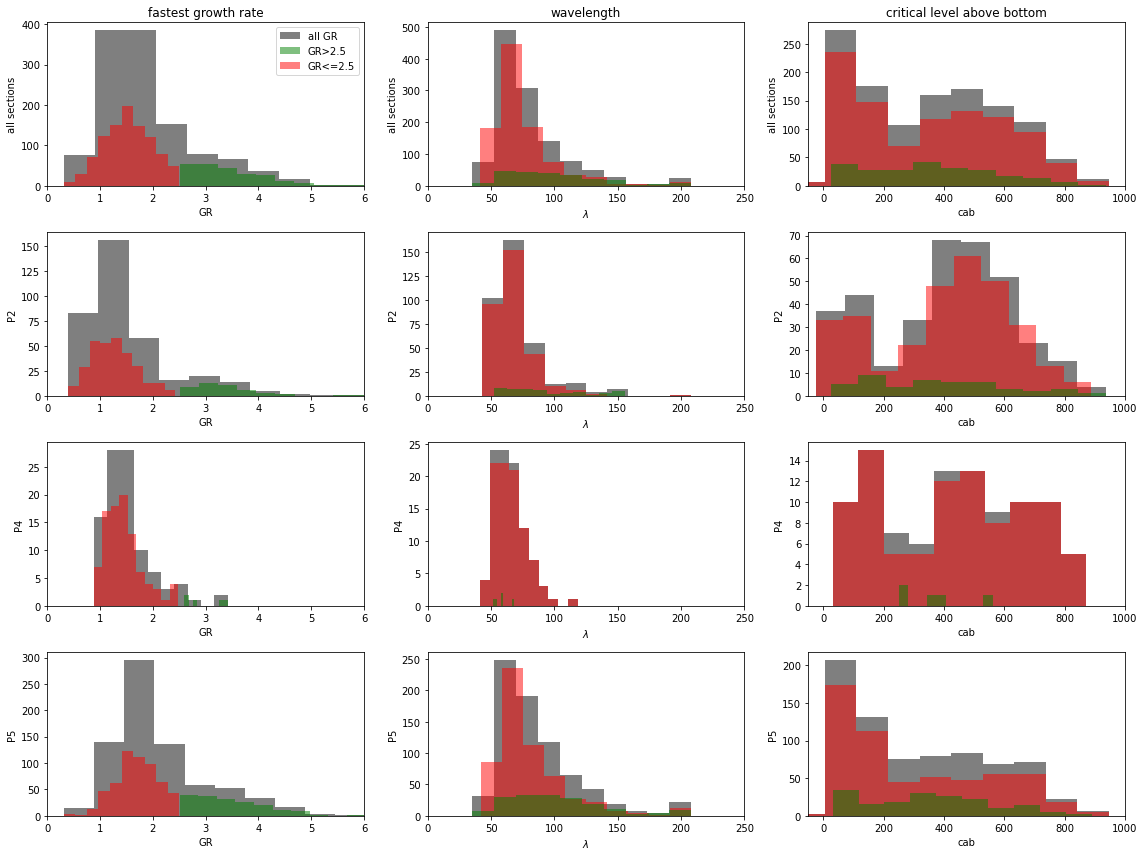

In [21]:
fig, ax =  plt.subplots(nrows=4, ncols=3, figsize=(16, 12))
# GR
GRc = 2.5
ax[0,0].hist(FGM_towyo.GR, facecolor='k', alpha=0.5, label='all GR')
ax[0,0].hist(FGM_towyo.GR[FGM_towyo.GR>GRc], facecolor='g', alpha=0.5, label=['GR>' + str(GRc)])
ax[0,0].hist(FGM_towyo.GR[FGM_towyo.GR<=GRc], facecolor='r', alpha=0.5, label=['GR<=' + str(GRc)])
ax[0,0].set_xlim([0,6]); ax[0,0].set_title("fastest growth rate"); ax[0,0].set_ylabel('all sections'); ax[0,0].set_xlabel('GR'); ax[0,0].legend()

ax[1,0].hist(FGM_towyo_P2.GR, facecolor='k', alpha=0.5, label='all GR')
ax[1,0].hist(FGM_towyo_P2.GR[FGM_towyo_P2.GR>GRc], facecolor='g', alpha=0.5, label=['GR>' + str(GRc)])
ax[1,0].hist(FGM_towyo_P2.GR[FGM_towyo_P2.GR<=GRc], facecolor='r', alpha=0.5, label=['GR<=' + str(GRc)])
ax[1,0].set_xlim([0,6]); ax[1,0].set_title(""); ax[1,0].set_ylabel('P2'); ax[1,0].set_xlabel('GR');

ax[2,0].hist(FGM_towyo_P4.GR, facecolor='k', alpha=0.5, label='all GR')
ax[2,0].hist(FGM_towyo_P4.GR[FGM_towyo_P4.GR>GRc], facecolor='g', alpha=0.5, label=['GR>' + str(GRc)])
ax[2,0].hist(FGM_towyo_P4.GR[FGM_towyo_P4.GR<=GRc], facecolor='r', alpha=0.5, label=['GR<=' + str(GRc)])
ax[2,0].set_xlim([0,6]); ax[2,0].set_title(""); ax[2,0].set_ylabel('P4'); ax[2,0].set_xlabel('GR');

ax[-1,0].hist(FGM_towyo_P5.GR, facecolor='k', alpha=0.5, label='all GR')
ax[-1,0].hist(FGM_towyo_P5.GR[FGM_towyo_P5.GR>GRc], facecolor='g', alpha=0.5, label=['GR>' + str(GRc)])
ax[-1,0].hist(FGM_towyo_P5.GR[FGM_towyo_P5.GR<=GRc], facecolor='r', alpha=0.5, label=['GR<=' + str(GRc)])
ax[-1,0].set_xlim([0,6]); ax[-1,0].set_title(""); ax[-1,0].set_ylabel('P5'); ax[-1,0].set_xlabel('GR');

# wavelength
wl = 2*np.pi/np.sqrt(FGM_towyo.K[:,0]**2 + FGM_towyo.K[:,1]**2)
ax[0,1].hist(wl, facecolor='k', alpha=0.5, label='all GR')
ax[0,1].hist(wl[FGM_towyo.GR<=GRc], facecolor='r', alpha=0.5, label=['GR<=' + str(GRc)])
ax[0,1].hist(wl[FGM_towyo.GR>GRc], facecolor='g', alpha=0.5, label=['GR>' + str(GRc)])
ax[0,1].set_xlim([0,250]); ax[0,1].set_title("wavelength"); ax[0,1].set_ylabel('all sections'); ax[0,1].set_xlabel('$\lambda$'); 

wl = 2*np.pi/np.sqrt(FGM_towyo_P2.K[:,0]**2 + FGM_towyo_P2.K[:,1]**2)
ax[1,1].hist(wl, facecolor='k', alpha=0.5, label='all GR')
ax[1,1].hist(wl[FGM_towyo_P2.GR<=GRc], facecolor='r', alpha=0.5, label=['GR<=' + str(GRc)])
ax[1,1].hist(wl[FGM_towyo_P2.GR>GRc], facecolor='g', alpha=0.5, label=['GR>' + str(GRc)])
ax[1,1].set_xlim([0,250]); ax[1,1].set_title(""); ax[1,1].set_ylabel('P2'); ax[1,1].set_xlabel('$\lambda$'); 

wl = 2*np.pi/np.sqrt(FGM_towyo_P4.K[:,0]**2 + FGM_towyo_P4.K[:,1]**2)
ax[2,1].hist(wl, facecolor='k', alpha=0.5, label='all GR')
ax[2,1].hist(wl[FGM_towyo_P4.GR<=GRc], facecolor='r', alpha=0.5, label=['GR<=' + str(GRc)])
ax[2,1].hist(wl[FGM_towyo_P4.GR>GRc], facecolor='g', alpha=0.5, label=['GR>' + str(GRc)])
ax[2,1].set_xlim([0,250]); ax[2,1].set_title(""); ax[2,1].set_ylabel('P4'); ax[2,1].set_xlabel('$\lambda$'); 

wl = 2*np.pi/np.sqrt(FGM_towyo_P5.K[:,0]**2 + FGM_towyo_P5.K[:,1]**2)
ax[-1,1].hist(wl, facecolor='k', alpha=0.5, label='all GR')
ax[-1,1].hist(wl[FGM_towyo_P5.GR<=GRc], facecolor='r', alpha=0.5, label=['GR<=' + str(GRc)])
ax[-1,1].hist(wl[FGM_towyo_P5.GR>GRc], facecolor='g', alpha=0.5, label=['GR>' + str(GRc)])
ax[-1,1].set_xlim([0,250]); ax[-1,1].set_title(""); ax[-1,1].set_ylabel('P5'); ax[-1,1].set_xlabel('$\lambda$'); 

# critical level above bottom
ax[0,-1].hist(FGM_towyo.cab, facecolor='k', alpha=0.5, label='all GR')
ax[0,-1].hist(FGM_towyo.cab[FGM_towyo.GR<=GRc], facecolor='r', alpha=0.5, label=['GR<=' + str(GRc)])
ax[0,-1].hist(FGM_towyo.cab[FGM_towyo.GR>GRc], facecolor='g', alpha=0.5, label=['GR>' + str(GRc)])
ax[0,-1].set_xlim([-50,1000]); ax[0,-1].set_title("critical level above bottom"); ax[0,-1].set_ylabel('all sections'); ax[0,-1].set_xlabel('cab'); 

ax[1,-1].hist(FGM_towyo_P2.cab, facecolor='k', alpha=0.5, label='all GR')
ax[1,-1].hist(FGM_towyo_P2.cab[FGM_towyo_P2.GR<=GRc], facecolor='r', alpha=0.5, label=['GR<=' + str(GRc)])
ax[1,-1].hist(FGM_towyo_P2.cab[FGM_towyo_P2.GR>GRc], facecolor='g', alpha=0.5, label=['GR>' + str(GRc)])
ax[1,-1].set_xlim([-50,1000]); ax[1,-1].set_title(""); ax[1,-1].set_ylabel('P2'); ax[1,-1].set_xlabel('cab'); 

ax[2,-1].hist(FGM_towyo_P4.cab, facecolor='k', alpha=0.5, label='all GR')
ax[2,-1].hist(FGM_towyo_P4.cab[FGM_towyo_P4.GR<=GRc], facecolor='r', alpha=0.5, label=['GR<=' + str(GRc)])
ax[2,-1].hist(FGM_towyo_P4.cab[FGM_towyo_P4.GR>GRc], facecolor='g', alpha=0.5, label=['GR>' + str(GRc)])
ax[2,-1].set_xlim([-50,1000]); ax[2,-1].set_title(""); ax[2,-1].set_ylabel('P4'); ax[2,-1].set_xlabel('cab'); 

ax[-1,-1].hist(FGM_towyo_P5.cab, facecolor='k', alpha=0.5, label='all GR')
ax[-1,-1].hist(FGM_towyo_P5.cab[FGM_towyo_P5.GR<=GRc], facecolor='r', alpha=0.5, label=['GR<=' + str(GRc)])
ax[-1,-1].hist(FGM_towyo_P5.cab[FGM_towyo_P5.GR>GRc], facecolor='g', alpha=0.5, label=['GR>' + str(GRc)])
ax[-1,-1].set_xlim([-50,1000]); ax[-1,-1].set_title(""); ax[-1,-1].set_ylabel('P5'); ax[-1,-1].set_xlabel('cab'); 

fig.tight_layout()

In [22]:
def datafromfile(data_name):
    data = sio.loadmat(mdirec + 'codes/' + data_name,squeeze_me = True,struct_as_record = False)
    type(data)
    dict.keys(data)

    # Growth rate, imaginary phase speed, real phase speed, numbers of zero-crossing, wave vector of the FGM
    GR = xr.DataArray(data['GR'], coords={"site": np.arange(len(data['LON']))}, dims=["site"], attrs={'longname': '$\sigma$: $hr^{-1}$'})
    CI = xr.DataArray(data['CI'], coords={"site": np.arange(len(data['LON']))}, dims=["site"])
    CR = xr.DataArray(data['CR'], coords={"site": np.arange(len(data['LON']))}, dims=["site"])
    II = xr.DataArray(data['II'], coords={"site": np.arange(len(data['LON']))}, dims=["site"], attrs={'longname': '0-crossings'})
    KFGM = xr.DataArray(data['KFGM'], coords={"site": np.arange(len(data['LON'])), "vector": ['k' , 'l']}, dims=["site" , "vector"])
    LON = xr.DataArray(data['LON'], coords={"site": np.arange(len(data['LON']))}, dims=["site"])
    LAT = xr.DataArray(data['LAT'], coords={"site": np.arange(len(data['LON']))}, dims=["site"])

    # profiles
    B = xr.DataArray(data['B'], coords={"z":data['zw'], "site": np.arange(len(data['LON']))}, dims=["z" , "site"])
    N2 = xr.DataArray(data['N2'], coords={"z":data['zw'], "site": np.arange(len(data['LON']))}, dims=["z" , "site"])
    Ri = xr.DataArray(data['Ri'], coords={"z":data['zw'], "site": np.arange(len(data['LON']))}, dims=["z" , "site"])
    V = xr.DataArray(data['V'], coords={"z":data['zw'], "site": np.arange(len(data['LON']))}, dims=["z" , "site"])
    Vz = xr.DataArray(data['Vz'], coords={"z":data['zw'], "site": np.arange(len(data['LON']))}, dims=["z" , "site"])
    Vzz = xr.DataArray(data['Vzz'], coords={"z":data['zw'], "site": np.arange(len(data['LON']))}, dims=["z" , "site"])

    # FGM in terms of w
    W = xr.DataArray(data['W'], coords={"z":data['zw'], "site": np.arange(len(data['LON']))}, dims=["z" , "site"])
    # critical levels
    CL = xr.DataArray(data['CL'], coords={"site": np.arange(len(data['LON'])), "n": np.arange(data['CL'].shape[-1])}, dims=["site" , "n"])

    # interface height, bottom height
    data0 = sio.loadmat(mdirec[:-7]+'/proc_data/'+data_name[6:-8]+'.mat',squeeze_me = True,struct_as_record = False)
    idep = xr.DataArray(data0['zo'], coords={"site": np.arange(len(data['LON']))}, dims=["site"])
    bdep = xr.DataArray(data0['bdepth'], coords={"site": np.arange(len(data['LON']))}, dims=["site"])


    FGM_towyo_ex = xr.Dataset({'GR': (['site'], 2*np.pi/GR/3600), 
                           'CI': (['site'], CI),
                           'CR': (['site'], CR),
                           'II': (['site'], II), 
                           'K': (['site','vector'], KFGM),
                           'LON': (['site'], LON), 
                           'LAT': (['site'], LAT), 
                           'zo': (['site'], idep), 
                           'bdepth': (['site'], -bdep), 
                           'b': (['z', 'site'], B),
                           'N2': (['z', 'site'], N2),
                           'Ri': (['z', 'site'], Ri),
                           'V': (['z', 'site'], V),
                           'Vz': (['z', 'site'], Vz),
                           'Vzz': (['z', 'site'], Vzz),
                           'W': (['z', 'site'], W),
                           'CL': (['site', 'n'], CL)},
                           coords={'site': np.arange(len(data['LON'])),
                                   'z': data['zw'],
                                   'n': np.arange(data['CL'].shape[-1])},
                           attrs={'title': 'FGM, tow-yo profiles, ex_'})
    return FGM_towyo_ex

FD and FG methods seem to have different results

Text(0, 0.5, 'Longitudinal wave length')

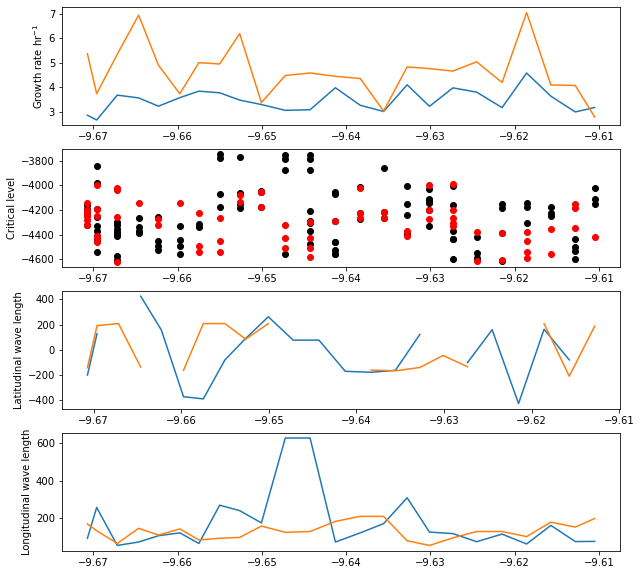

In [23]:
# FD and FG 

FGM_towyo_ex1 = datafromfile('TG_SI_TY_P2_00_2012_ex1.mat')
FGM_towyo_ex2 = datafromfile('TG_SI_TY_P2_00_2012_ex2.mat')

fig, ax =  plt.subplots(nrows=4, ncols=1, figsize=(10, 10))
# 1. GR
ax[0].plot(FGM_towyo_ex1.LAT,FGM_towyo_ex1.GR) #FD
ax[0].plot(FGM_towyo_ex2.LAT,FGM_towyo_ex2.GR) #FG
ax[0].set_ylabel("Growth rate hr$^{-1}$")
# 2. CL
ax[1].plot(FGM_towyo_ex1.LAT,FGM_towyo_ex1.CL,'ko') #FD
ax[1].plot(FGM_towyo_ex2.LAT,FGM_towyo_ex2.CL,'ro') #FG
ax[1].set_ylabel("Critical level")
# 3. K and L
# K
ax[2].plot(FGM_towyo_ex1.LAT,2*np.pi/FGM_towyo_ex1.K[:,0]) #FD
ax[2].plot(FGM_towyo_ex2.LAT,2*np.pi/FGM_towyo_ex2.K[:,0]) #FG
ax[2].set_ylabel("Latitudinal wave length")
# L
ax[-1].plot(FGM_towyo_ex1.LAT,2*np.pi/FGM_towyo_ex1.K[:,-1]) #FD
ax[-1].plot(FGM_towyo_ex2.LAT,2*np.pi/FGM_towyo_ex2.K[:,-1]) #FG
ax[-1].set_ylabel("Longitudinal wave length")


Text(0, 0.5, 'Longitudinal wave length')

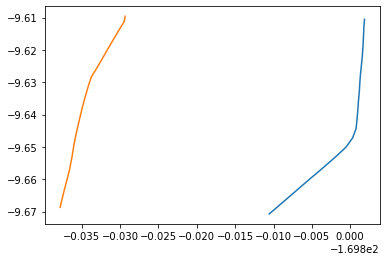

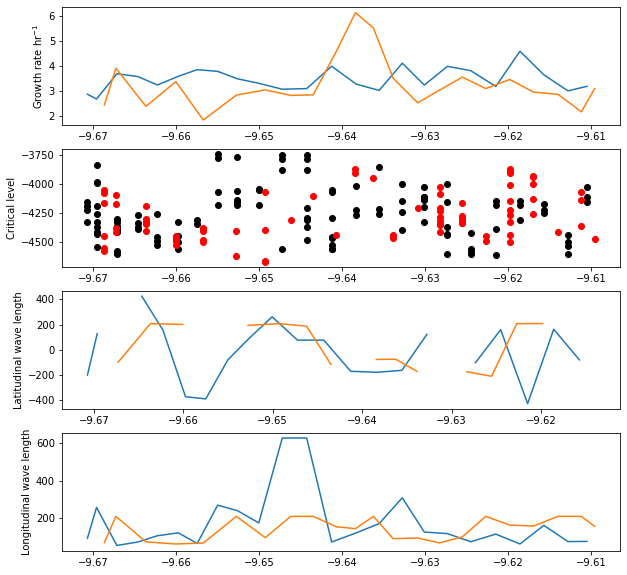

In [24]:
# another tow-yo section

FGM_towyo_ex = datafromfile('TG_SI_TY_P2_01_2012_ex1.mat')

plt.plot(FGM_towyo_ex1.LON,FGM_towyo_ex1.LAT)
plt.plot(FGM_towyo_ex.LON,FGM_towyo_ex.LAT)

fig, ax =  plt.subplots(nrows=4, ncols=1, figsize=(10, 10))
# 1. GR
ax[0].plot(FGM_towyo_ex1.LAT,FGM_towyo_ex1.GR)
ax[0].plot(FGM_towyo_ex.LAT,FGM_towyo_ex.GR)
ax[0].set_ylabel("Growth rate hr$^{-1}$")
# 2. CL
ax[1].plot(FGM_towyo_ex1.LAT,FGM_towyo_ex1.CL,'ko') 
ax[1].plot(FGM_towyo_ex.LAT,FGM_towyo_ex.CL,'ro')
ax[1].set_ylabel("Critical level")
# 3. K and L
# K
ax[2].plot(FGM_towyo_ex1.LAT,2*np.pi/FGM_towyo_ex1.K[:,0])
ax[2].plot(FGM_towyo_ex.LAT,2*np.pi/FGM_towyo_ex.K[:,0])
ax[2].set_ylabel("Latitudinal wave length")
# L
ax[-1].plot(FGM_towyo_ex1.LAT,2*np.pi/FGM_towyo_ex1.K[:,-1]) 
ax[-1].plot(FGM_towyo_ex.LAT,2*np.pi/FGM_towyo_ex.K[:,-1]) 
ax[-1].set_ylabel("Longitudinal wave length")


<ipython-input-25-6e1d5eec3edd>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolor(FGM_towyo_ex1.LON,FGM_towyo_ex1.z,FGM_towyo_ex1.W.real,cmap=cm.RdBu,vmin=-.2, vmax=.2)


(-4800.0, -3900.0)

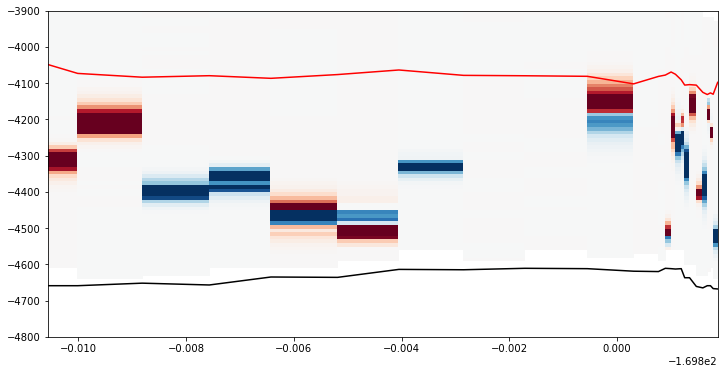

In [25]:
fig, ax =  plt.subplots(nrows=1, ncols=1, figsize=(12, 6))

ax.pcolor(FGM_towyo_ex1.LON,FGM_towyo_ex1.z,FGM_towyo_ex1.W.real,cmap=cm.RdBu,vmin=-.2, vmax=.2)
ax.plot(FGM_towyo_ex1.LON,FGM_towyo_ex1.bdepth,'k')
ax.plot(FGM_towyo_ex1.LON,FGM_towyo_ex1.zo,'r')
ax.set_ylim([-4800,-3900])